🔎 Dataset Overview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

📈 First 5 Rows
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 

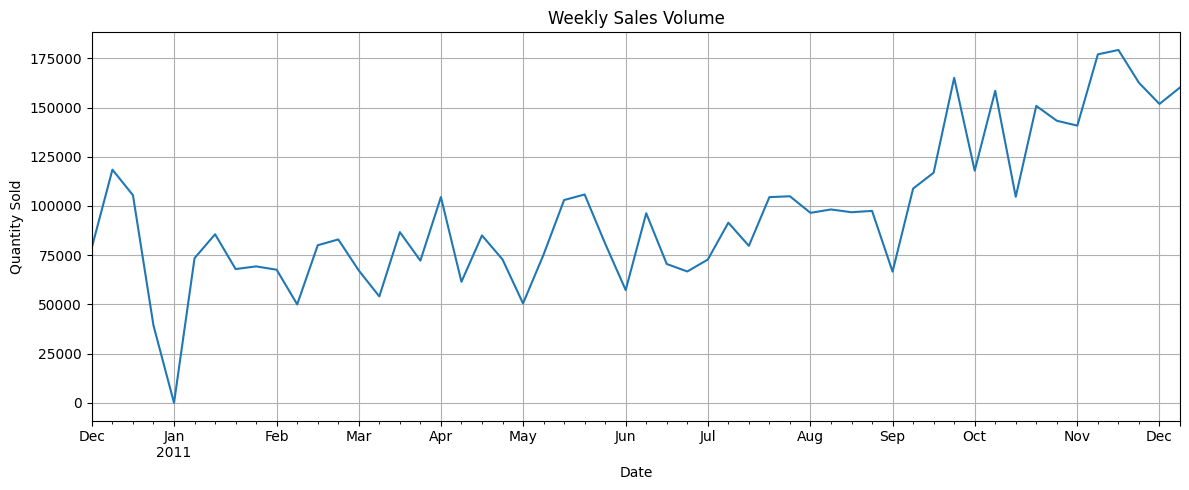

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Load dataset
df = pd.read_csv("raw_data.csv", encoding='ISO-8859-1')

# Basic info
print("🔎 Dataset Overview")
print(df.info())
print("\n📈 First 5 Rows")
print(df.head())

# Check for missing values
print("\n🧼 Missing Values")
print(df.isnull().sum())

# Summary stats
print("\n📊 Summary Statistics")
print(df.describe())

# Unique values
print("\n🧾 Unique CustomerIDs:", df['CustomerID'].nunique())
print("🛍️ Unique Products:", df['Description'].nunique())

# Most purchased items
top_items = df['Description'].value_counts().head(10)
print("\n🏆 Top 10 Most Purchased Items:")
print(top_items)

# Total sales per country (optional)
sales_per_country = df.groupby('Country')['Quantity'].sum().sort_values(ascending=False)
print("\n🌍 Top Countries by Quantity Sold:")
print(sales_per_country.head())


# Sales over time
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.set_index('InvoiceDate')['Quantity'].resample('W').sum().plot(figsize=(12, 5))
plt.title('Weekly Sales Volume')
plt.ylabel('Quantity Sold')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

## Drop

In [8]:
# Load dataset
df = df.dropna(subset=['CustomerID'])
df.drop_duplicates(inplace=True)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [17]:
df.to_csv("cleaned_data.csv", index=False)

## Pareto Principle (80/20 Rule) — Small group = majority revenue

🔁 1129 customers (~26%) contribute to 80% of revenue.


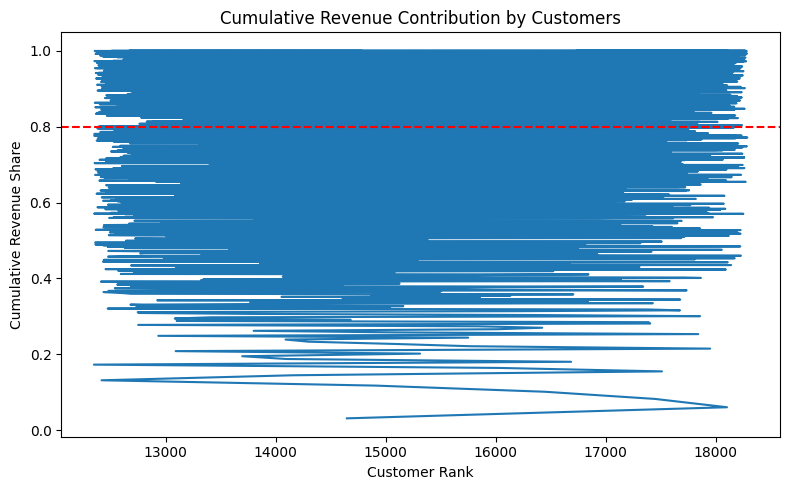

In [9]:
# Calculate monetary value per customer
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
revenue_per_customer = df.groupby('CustomerID')['TotalAmount'].sum().sort_values(ascending=False)

# Cumulative revenue share
cumulative_share = revenue_per_customer.cumsum() / revenue_per_customer.sum()

# Find how many customers contribute to 80% of revenue
top_80_cutoff = cumulative_share[cumulative_share <= 0.8]
print(f"🔁 {len(top_80_cutoff)} customers (~{len(top_80_cutoff)/df['CustomerID'].nunique():.0%}) contribute to 80% of revenue.")

# Optional plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
cumulative_share.plot()
plt.axhline(y=0.8, color='r', linestyle='--')
plt.title("Cumulative Revenue Contribution by Customers")
plt.xlabel("Customer Rank")
plt.ylabel("Cumulative Revenue Share")
plt.tight_layout()
plt.show()

## Low Frequency / Inactive Customers


📉 Purchase Frequency Distribution:
count    4338.000000
mean        4.272015
std         7.697998
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       209.000000
Name: InvoiceNo, dtype: float64

🔎 1493 customers (~34%) purchased only once.


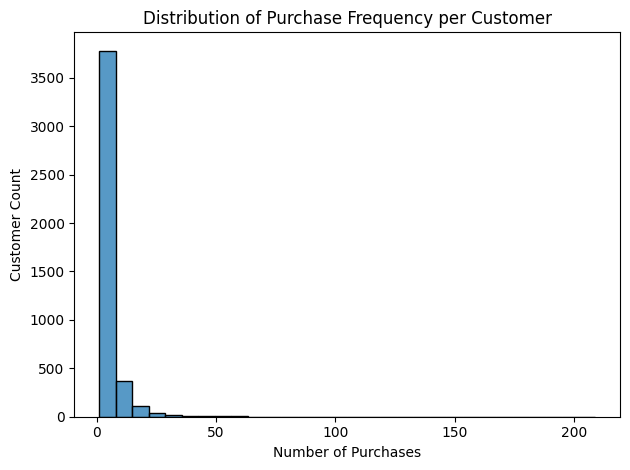

In [10]:
# Frequency per customer
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Show distribution
print("\n📉 Purchase Frequency Distribution:")
print(frequency.describe())

# Threshold for low frequency (e.g., only 1 transaction)
low_freq_count = (frequency == 1).sum()
print(f"\n🔎 {low_freq_count} customers (~{low_freq_count/len(frequency):.0%}) purchased only once.")

# Optional plot
import seaborn as sns
sns.histplot(frequency, bins=30, kde=False)
plt.title("Distribution of Purchase Frequency per Customer")
plt.xlabel("Number of Purchases")
plt.ylabel("Customer Count")
plt.tight_layout()
plt.show()

# rfm data

## Clear Differences in Customer Behavior

In [11]:
# Create RFM table
snapshot = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [ ]:
#rfm.to_csv("feature_eng_data.csv", index=False)

In [12]:
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2048.688081
std,1721.808492,100.014169,7.697998,8985.230220
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,306.482500
50%,15299.500000,51.000000,2.000000,668.570000
75%,16778.750000,142.000000,5.000000,1660.597500
max,18287.000000,374.000000,209.000000,280206.020000


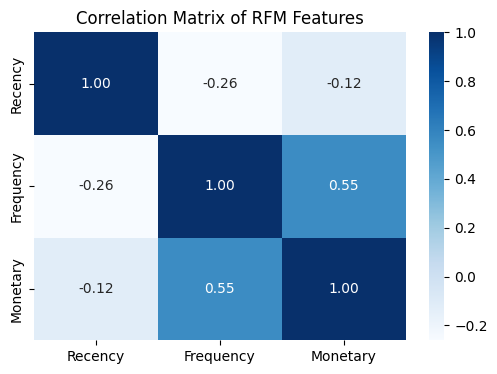

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = rfm[['Recency', 'Frequency', 'Monetary']].corr()

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title("Correlation Matrix of RFM Features")
plt.show()


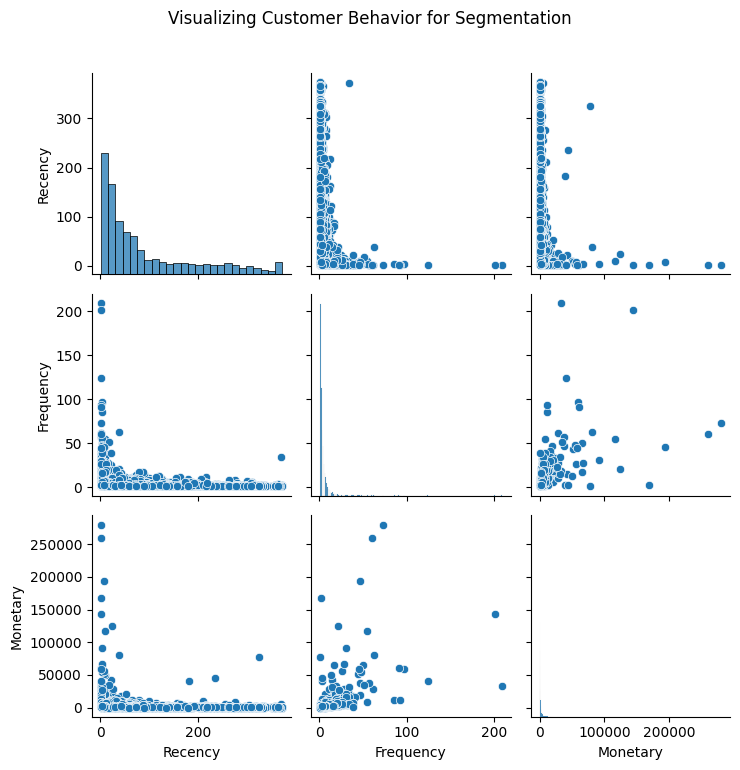

In [14]:
# Pairplot to show clustering tendency
sns.pairplot(rfm[['Recency', 'Frequency', 'Monetary']])
plt.suptitle("Visualizing Customer Behavior for Segmentation", y=1.02)
plt.tight_layout()
plt.show()


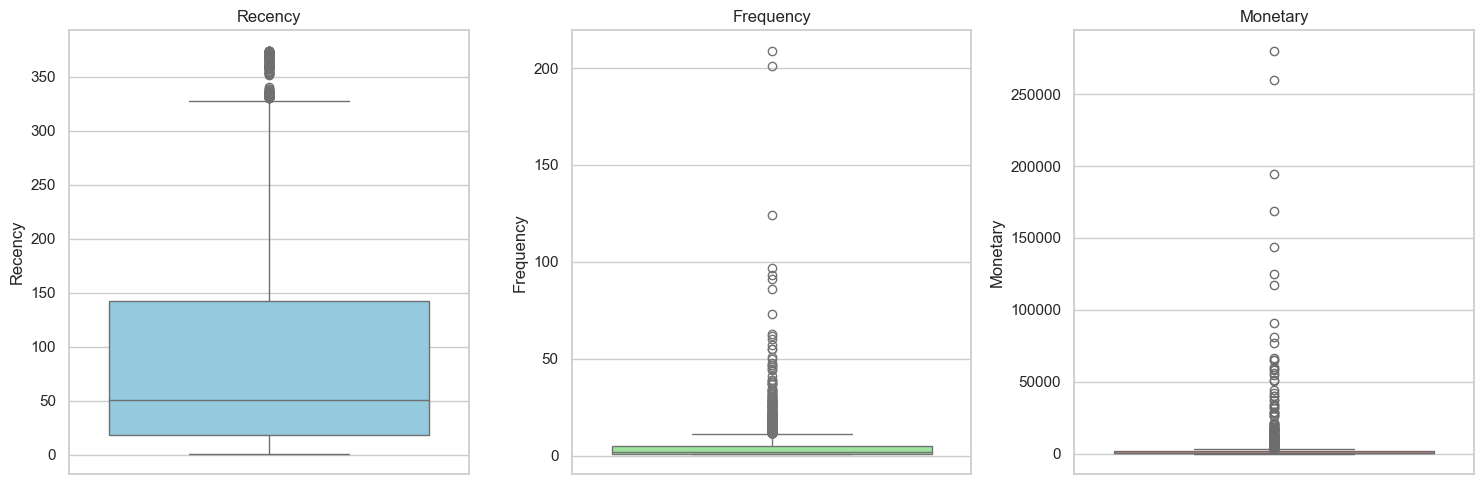

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Set the plot style
sns.set(style="whitegrid")

# Create boxplots for RFM features
plt.figure(figsize=(15, 5))

# Recency boxplot
plt.subplot(1, 3, 1)
sns.boxplot(y=rfm['Recency'], color='skyblue')
plt.title('Recency')

# Frequency boxplot
plt.subplot(1, 3, 2)
sns.boxplot(y=rfm['Frequency'], color='lightgreen')
plt.title('Frequency')

# Monetary boxplot
plt.subplot(1, 3, 3)
sns.boxplot(y=rfm['Monetary'], color='salmon')
plt.title('Monetary')

plt.tight_layout()
plt.show()
